In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def load_systems_dataframe(ulx_only=False, beamed=False, half_opening_l_45=False):
    systems_df_path = Path('../data/processed/all_systems_df.csv')
    df = pd.read_csv(systems_df_path)
    if ulx_only:
        df = df[df['Lx'] > 1E39]
    if beamed:
        df = df[df['b'] < 1]
    if half_opening_l_45:
        df = df[df['theta_half_deg'] < 45]
        
    df = df.drop(['Unnamed: 0'], axis=1)
    return df

In [102]:
systems_df = load_systems_dataframe(True, False, False)

In [103]:
systems_df

,mdot,m,Z,tage,is_bh,mdot_gs,LEdd,MEdd,mdot_ratio,XLsph,...,r_isco_nospin,r_isco,r_sph,r_out,P_inflow_at_rsph,P_envelope,P_wind,P_inflow_days,P_envelope_days,P_wind_days
0,3.90,25.9,0.0002,10,1,2.458077e+20,3.108000e+39,4.144000e+19,5.931652,5.573986e+39,...,6.0,6,35.589913,NaN,1.944430e+00,NaN,NaN,0.000023,NaN,NaN
1,2.70,28.3,0.0002,10,1,1.701745e+20,3.396000e+39,4.528000e+19,3.758272,2.043685e+39,...,6.0,6,22.549630,NaN,4.998411e-01,NaN,NaN,0.000006,NaN,NaN
2,1.70,15.5,0.0002,10,1,1.071469e+20,1.860000e+39,2.480000e+19,4.320441,1.567971e+39,...,6.0,6,25.922645,NaN,4.320933e-01,NaN,NaN,0.000005,NaN,NaN
3,36.00,24.6,0.0002,10,1,2.268994e+21,2.952000e+39,3.936000e+19,57.647201,9.090313e+41,...,6.0,6,345.883207,65619.897984,1.229021e+03,4.423554e+07,3.854791e+09,0.014225,5.119854e+02,4.461564e+04
4,6.70,28.8,0.0002,10,1,4.222850e+20,3.456000e+39,4.608000e+19,9.164170,1.710894e+40,...,6.0,6,54.985021,618.449057,7.883242e+00,9.972957e+02,7.363178e+03,0.000091,1.154277e-02,8.522197e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5715,1.50,6.7,0.0020,200,1,9.454141e+19,8.040000e+38,1.072000e+19,8.819161,3.642162e+39,...,6.0,6,52.914968,551.196379,1.639534e+00,1.779001e+02,1.239135e+03,0.000019,2.059029e-03,1.434184e-02
5845,0.70,8.1,0.0020,200,1,4.411932e+19,9.720000e+38,1.296000e+19,3.404269,4.595061e+38,...,6.0,6,20.425613,NaN,1.023992e-01,NaN,NaN,0.000001,NaN,NaN
8227,0.39,1.2,0.0020,500,0,2.458077e+19,1.440000e+38,1.920000e+18,12.802483,1.535948e+39,...,6.0,6,76.814896,1686.192176,8.605225e+02,4.146536e+05,5.197360e+06,0.009960,4.799232e+00,6.015463e+01
10258,0.48,1.5,0.0020,500,0,3.025325e+19,1.800000e+38,2.400000e+18,12.605521,1.853185e+39,...,6.0,6,75.633128,1609.559078,1.028952e+03,4.659988e+05,5.694666e+06,0.011909,5.393505e+00,6.591048e+01


In [104]:
curve_classifications = pd.read_csv('../data/processed/curve_classications.csv')

In [105]:
curve_classifications

,system_id,theta,dincl,inclination,lc_min,lc_max,N_lim,classification
0,3,12.03,0,0,22.130920,22.130920,0.032583,alive
1,3,12.03,0,1,22.416954,22.416954,0.032583,alive
2,3,12.03,0,2,22.629745,22.629745,0.032583,alive
3,3,12.03,0,3,22.745117,22.745117,0.032583,alive
4,3,12.03,0,4,22.950842,22.950842,0.032583,alive
...,...,...,...,...,...,...,...,...
514873,17261,4.58,45,86,0.000004,0.474002,0.320879,transient
514874,17261,4.58,45,87,0.000004,0.447798,0.320879,transient
514875,17261,4.58,45,88,0.000004,0.410134,0.320879,transient
514876,17261,4.58,45,89,0.000004,0.387256,0.320879,transient


In [106]:
# Fast BH sampler

In [118]:
def create_keys(selected_systems, selected_dincls, selected_inclinations,):
    a = np.core.defchararray.add(selected_systems.astype(str), '-')
    b = np.core.defchararray.add(selected_dincls.astype(str), '-')
    keys = np.core.defchararray.add(a,b)
    keys = np.core.defchararray.add(keys,selected_inclinations.astype(str))
    return keys

In [119]:
# Classication dict
keys = (curve_classifications['system_id'].astype(str) +
        '-' + curve_classifications['dincl'].astype(str) +
        '-' + curve_classifications['inclination'].astype(str)).values
classications = curve_classifications['classification'].values
class_dict = dict(zip(keys,classications))

In [120]:
ns_systems = systems_df[systems_df['is_bh'] == 0].index
bh_systems = systems_df[systems_df['is_bh'] == 1].index

In [121]:
res = []
number_of_repeats = 100
for i in range(number_of_repeats):
    for bh_ratio in np.arange(0,1.05,0.05):
        ns_ratio = 1 - bh_ratio

        bh_weights = [bh_ratio/len(bh_systems)]*len(bh_systems)
        ns_weights = [ns_ratio/len(ns_systems)]*len(ns_systems)

        selected_systems = np.random.choice([*bh_systems, *ns_systems], size=500, p=[*bh_weights, *ns_weights])
        selected_dincls = np.random.randint(0,46, size=500)
        selected_inclinations = np.random.randint(0,91, size=500)
        selected_keys = create_keys(selected_systems, selected_dincls, selected_inclinations)

        res_classications = [class_dict.get(key) for key in selected_keys]

        # None systems correspond to opening angles > 45 and are considered alive
        N_alive = res_classications.count('alive') + res_classications.count(None)
        N_transient = res_classications.count('transient')
        N_dead = res_classications.count('dead')

        res.append([bh_ratio, N_alive, N_transient, N_dead])

In [122]:
res_df = pd.DataFrame(res, columns=['bh_ratio', 'alive', 'transient','dead'])

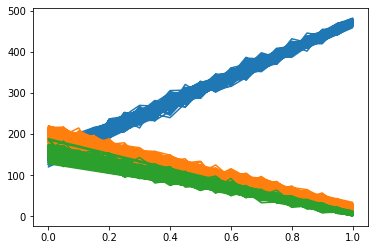

In [123]:
plt.plot(res_df['bh_ratio'], res_df['alive'])
plt.plot(res_df['bh_ratio'], res_df['transient'])
plt.plot(res_df['bh_ratio'], res_df['dead'])